## Contrôle des feux de signalisation

Ce programme présente une implémentation d'un controller step-based décrit dans l'article "Guidelines for Action Space Definition in Reinforcement Learning-Based Traffic Signal Control Systems" de Maxime Treca, Julian Garbiso, Dominique Barth.

L'objet d'étude est une intersection composée de 4 routes qui arrivent de chaque direction Nord, Sud, Est, Ouest


<img src="files/figures/intersection.jpg" width="500px"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1) Environnement

In [2]:
class Vehicule:
    def __init__(self, approach):
        self.approach = approach
        self.waiting_time = 0 #temps d'attente du véhicule
        
    def update_waiting_time(self):
        self.waiting_time += 1
        
    def get_waiting_time(self):
        return self.waiting_time

In [3]:
class IntersectionEnvironment:
    
    def __init__(self, d_min, d_max, n_step,tau, controller_type = 'step-based'):
        #durée min et max d'une phase
        self.d_min = d_min
        self.d_max = d_max
        
        self.n_step = n_step
        self.tau = tau
        
        #cycle Ψ
        self.signal_cycle = ['ψ1', 'ψT', 'ψ2', 'ψT'] 
        self.controller_type = controller_type
        
        #Durée initiale de chaque phase de ψ
        self.phase_duration = {
            'ψ1': self.d_min,
            'ψ2': self.d_min,
            'ψT': 5
        }
        
        #liste des véhicules sur les 4 routes Nord, Sud, Est, Ouest
        self.approaches ={
            'N' :[],
            'S' :[],
            'W' :[],
            'E':[]
        }
        
        #Indice et durée de la phase initiale
        self.current_phase_idx = 0
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
        self.time_since_last_phase = 0
        
        #Congestion associée à chaque phase
        self.congestion = {'ψ1': 0, 'ψ2': 0}
        
        #temps attente de chaque phase
        self.phase_waiting_time = {
            'ψ1': 0,
            'ψ2': 0
        }
        self.old_cumulated_waiting_time = 0

        #temps d'attente cumulé
        self.cumulated_waiting_time = 0
        
        #temps t actuel
        self.time_elapsed = 0
        
        #nombre de départ de véhicules pour chaque phase
        self.departure =  {
            'ψ1': 0,
            'ψ2': 0
        }
        
        
    def reset(self):
        self.phase_duration = {
            'ψ1': self.d_min,
            'ψ2': self.d_min,
            'ψT': 5
        }
        self.approaches ={
            'N' :[],
            'S' :[],
            'W' :[],
            'E':[]
        }
        self.current_phase_idx = 0
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
        self.time_since_last_phase = 0
        self.congestion = {'ψ1': 0, 'ψ2': 0}
        
        self.time_elapsed = 0
        self.departure =  {
            'ψ1': 0,
            'ψ2': 0
        }
        self.cumulated_waiting_time = 0
        self.old_cumulated_waiting_time = 0
        self.phase_waiting_time = {
            'ψ1': 0,
            'ψ2': 0
        }
        return ('ψ1', self.phase_duration['ψ1'], self.congestion['ψ1'], self.congestion['ψ2'])
    
    def step(self, action):
        #print( " t = ", self.time_elapsed,", phase", self.signal_cycle[self.current_phase_idx] )
        terminal = False
        reward = 0
        self.time_elapsed+=1
        self.time_since_last_phase += 1
        
        
        # Generation du traffic
        self.generate_trafic(self.tau)
        
        # Mise à jour du traffic
        self.update_trafic()
        
        #Mise à jour du temps d'attente des voitures
        self.update_waiting_time(self.current_phase_idx)
        
        #temps d'attente cumulé
        self.cumulated_waiting_time = self.get_cumulated_waiting_time()

        #Phase de transition ψT
        if self.time_since_last_phase == self.current_phase_duration and self.signal_cycle[self.current_phase_idx] == 'ψT' :
            self.time_since_last_phase = 0
            self.switch_phase()
         
        #Decision point
        elif self.time_since_last_phase == self.current_phase_duration and self.signal_cycle[self.current_phase_idx] != 'ψT' :
            
            #temps d'attente cumulé au dernier point de decision
            self.old_cumulated_waiting_time = self.cumulated_waiting_time
            
            if action == 0: # Prolonger la phase actuelle
                if self.current_phase_duration == self.d_max:
                    self.time_since_last_phase = 0
                    self.switch_phase()
                elif self.current_phase_duration + self.n_step <= self.d_max:
                    self.current_phase_duration += self.n_step
                elif self.current_phase_duration + self.n_step > self.d_max:
                    self.time_since_last_phase = 0
                    self.switch_phase()
                    
            else: # Passer à la prochaine phase du cycle
                self.time_since_last_phase = 0
                self.switch_phase()
        
        #congestion au temps t
        self.congestion = self.update_congestion() 
        
        #différence entre le temps d'attente cumulé au dernier point de décision et le temps d'attente cumulé au temps t
        reward = self.old_cumulated_waiting_time - self.cumulated_waiting_time
        
        #etat: phase actuelle, durée actuelle et niveaux de congestion
        state = (self.signal_cycle[self.current_phase_idx],self.time_since_last_phase, self.congestion['ψ1'], self.congestion['ψ2'])
        
        #un scenario dure 10,000 steps
        if self.time_elapsed == 10000: 
            terminal = True
        return state,reward,terminal
    
    #changement de phase pour un agent step-based
    def switch_phase(self):
        #Passage a la prochaine phase du cycle Ψ 
        self.current_phase_idx = (self.current_phase_idx + 1) % len(self.signal_cycle) 
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
        
    
    def generate_trafic(self,tau):
        # Generation du traffic avec deux processus Poisson
        λ = (0.5 - tau)
        poisson_1 = np.random.poisson(λ/4, 4)
        poisson_2 = np.random.poisson(tau/2, 2)
        #Arrivées uniformes
        if poisson_1[0]:
            self.approaches['N'].append(Vehicule('N'))
        if poisson_1[1]:
            self.approaches['S'].append(Vehicule('S'))
        if poisson_1[2]:
            self.approaches['W'].append(Vehicule('W'))
        if poisson_1[3]:
            self.approaches['E'].append(Vehicule('E'))
        
        #Arrivées Nord et Sud
        if poisson_2[0]:
            self.approaches['N'].append(Vehicule('N'))
        if poisson_2[1]:
            self.approaches['S'].append(Vehicule('S'))
        
    def update_trafic(self):
        
        #Nombre de départ de voiture pour 1 step
        depart = 1
        
        for i in range(depart):
            #phase ψ1
            if self.current_phase_idx == 0 :
                
                if len(self.approaches['N']) > 0:
                    self.phase_waiting_time['ψ1'] += self.approaches['N'][0].get_waiting_time()
                    #on enleve le premier véhicule de la liste de l'approche associée
                    self.approaches['N'].pop(0) 
                    #màj du nombre de départ pour la phase ψ1
                    self.departure['ψ1'] +=1
                    
                if len(self.approaches['S']) > 0:
                    self.phase_waiting_time['ψ1'] += self.approaches['S'][0].get_waiting_time()
                    self.approaches['S'].pop(0) 
                    self.departure['ψ1'] +=1

            #phase ψ2
            elif self.current_phase_idx == 2:
                
                if len(self.approaches['W']) > 0:
                    self.phase_waiting_time['ψ2'] += self.approaches['W'][0].get_waiting_time()
                    self.approaches['W'].pop(0)
                    self.departure['ψ2'] +=1
                    
                if len(self.approaches['E']) > 0:
                    self.phase_waiting_time['ψ2'] += self.approaches['E'][0].get_waiting_time()
                    self.approaches['E'].pop(0)
                    self.departure['ψ2'] +=1
                  
    def update_congestion(self):
        #calcul de la congestion
        self.congestion['ψ1'] = (len(self.approaches['N']) + len(self.approaches['S']))%3
        self.congestion['ψ2'] = (len(self.approaches['W']) + len(self.approaches['E']))%3
        return self.congestion
    
    def update_waiting_time(self,current_phase):
        if current_phase == 0: #Si la phase actuelle est la phase ψ1
            #on met à jour le temps d'attente des voitures sur les approches de la phase ψ2
            for v in self.approaches['W']:
                v.update_waiting_time()
            for w in self.approaches['E']:
                w.update_waiting_time()
        if current_phase == 2:#Si la phase actuelle est la phase ψ2
            #on met à jour le temps d'attente des voitures sur les approches de la phase ψ1
            for v in self.approaches['N']:
                v.update_waiting_time()
            for w in self.approaches['S']:
                w.update_waiting_time()
    
    def get_cumulated_waiting_time(self):
        #temps d'attente totale : cumul des temps d'attente des voitures sur chaque approche
        total = 0
        for v in self.approaches['N']:
                total += v.get_waiting_time()
        for w in self.approaches['S']:
                total += w.get_waiting_time()
        for v in self.approaches['W']:
                total += v.get_waiting_time()
        for w in self.approaches['E']:
                total += w.get_waiting_time()
        return total
        
        

## 2) Agent

In [4]:
class Agent:
    def __init__(self, alpha, gamma, epsilon):
        self.alpha = alpha
        self.action_space = [0, 1]  # 0 : prolongement de la phase actuelle de n steps, 1 : passer a la prochaine phase du cycle
        self.gamma = gamma
        self.epsilon = epsilon
        self.tableauQ = {}

    def action(self, etat):
        if np.random.uniform() < self.epsilon:
            # Exploration
            return np.random.choice(self.action_space)
        else:
            # Exploitation
            return np.argmax([self.get_action_value(etat, a) for a in self.action_space])
                

    def updateQ(self, etat, action, reward, prochainEtat):
        ancienneValeur = self.get_action_value(etat, action)
        prochainMax = np.max([self.get_action_value(prochainEtat, a) for a in self.action_space])
        nouvelleValeur = (1 - self.alpha) * ancienneValeur + self.alpha * (reward + self.gamma * prochainMax)
        self.tableauQ[(etat, action)] = nouvelleValeur
        
    def get_action_value(self, etat, action):
        if (etat, action) not in self.tableauQ:
            self.tableauQ[(etat, action)] = 0
        return self.tableauQ[(etat, action)]


## 3) Simulation

In [5]:
def simulation(nbiter,n_step,d_min,d_max, alpha,gamma,epsilon,tau):
    
    list_log = []
    average_phase2_duration = []
    #environnement
    intersection = IntersectionEnvironment(d_min,d_max,n_step,tau)
    
    #agent
    print("********Simulation pour n_step =", n_step, "********")
    agent = Agent(alpha, gamma ,epsilon)
    
    for ne in range(nbiter):
        state = intersection.reset()
        terminal = False
        print("Iteration ", ne+1)

        while not terminal:
            #print("nb de voiture sur l'approche Nord",intersection.approaches["N"])
            action = agent.action(state)
            next_state,reward, terminal = intersection.step(action)

            if state[0] != 'ψT': #on vérifie que l'on est pas dans un état de transition
                agent.updateQ(state,action,reward,next_state)
            state = next_state

        #print("/// RESULTATS ///")

        average_phase1 = intersection.phase_waiting_time['ψ1']/intersection.departure['ψ1']
        average_phase2 = intersection.phase_waiting_time['ψ2']/intersection.departure['ψ2']
        #print("Temps d'attente moyen ψ1 :", average_phase1)
        #print("Temps d'attente moyen ψ2 :", average_phase2)
        #print("Temps d'attente moyen :", (average_phase1+average_phase2)/2)
        list_log.append((average_phase1+average_phase2)/2)
    return list_log



In [6]:
simul5 = []
simul15 = []

nbiter = 40
d_min = 5
d_max = 45

alpha = 0.01
gamma = 0.5
epsilon = 0.05
tau = 0.10

In [7]:
simul5= simulation(nbiter,5,d_min,d_max, alpha,gamma,epsilon, tau)
simul15= simulation(nbiter,15,d_min,d_max, alpha,gamma,epsilon, tau)

********Simulation pour n_step = 5 ********
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
********Simulation pour n_step = 15 ********
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Itera

## 4) Comparaison pour différentes valeurs de n step

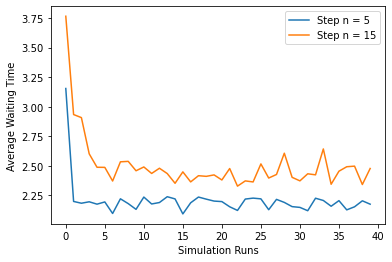

In [8]:
plt.plot(simul5,  label = 'Step n = 5')
plt.plot(simul15,  label = 'Step n = 15')

plt.xlabel('Simulation Runs')
plt.ylabel('Average Waiting Time')
plt.legend()